# Featurize Spectra from XY files into polynomial coefficient files.

Generates polynomial featurized XY files; takes as input XY files and produces files with polynomial fits performed.

## This notebook requires that the TRIXS repo is in your Python path.

That can be found here: https://github.com/TRI-AMDD/trixs.


In [1]:
# Set where the spectral data (XY files) are
storage_directory = './spectral_data'


# Define what transition metal oxides will be covered
target_elements_groups=[('Ti','O'),('V','O'),('Cr','O'),
                        ('Mn','O'),('Fe','O'),('Co','O'),
                        ('Ni','O'),('Cu','O')]

target_metals = set(['Co','Ni','Fe','Cr','V','Mn','Cu','Ti'])
target_elements_sets =[set(pair) for pair in target_elements_groups]

# Colors for later plotting!
colors_by_pair = {('Ti','O'):'orangered',
                  ('V','O'):'darkorange',
                  ('Cr','O'):'gold',
                  ('Mn','O'):'seagreen',
                  ('Fe','O'):'dodgerblue',
                  ('Co','O'):'navy',
                  ('Ni','O'):'rebeccapurple',
                  ('Cu','O'):"mediumvioletred"}


In [2]:
import os
for figure_write_folder in ['./figures_feffnorm','./figures_maxnorm']:
    try: 
        os.mkdir(figure_write_folder) 
    except OSError as error: 
        pass

# Import Relevant Functions

In [3]:
import sys
import matplotlib
import json
import numpy as np
import matplotlib.pyplot as plt

#sys.path.append(os.path.join(os.getcwd(), '..'))  # TRIXS path if not automatically detected
from trixs.spectra.core import XAS_Spectrum
from trixs.spectra.spectrum_featurize import polynomialize_by_idx, gauge_polynomial_error

from tqdm.notebook import tqdm

## Define helper functions for quality control of spectra

In [4]:
def prune_outliers(mu):
    """
    Given an absorption spectra, check on three unphysical ways we saw FEFF spectra behave for a small
    number of outlying data sets:
    1. A strange absorption pattern in which the absorption increases, rather than decays, in the XAFS region
    2. Unusually high absorption value
    3. A spuriously high peak-- larger than the edge's peak-- in the pre-edge region.
    """
    
    if mu[-1]==np.max(mu):
        return False
    
    if np.max(mu)>3:
        return False
    
    if np.max(mu) in mu[:10]:
        return False
    
    return True


In [5]:
def test_poly_error_fit(X_set,idxs,x_domain,error_bound=.1, use_norm = True):
    """
    Test multiple polynomials to see how their error compars to a cutoff bound
    """
    idx_keep = []
    
    for spec,idx in zip(X_set,idxs):
        
        within_bound = one_shot_poly_error_fit(x_domain,spec,
                                               use_norm=use_norm,error_bound=error_bound)
        
        if not within_bound:
            continue
        idx_keep.append(idx)
            
    print("Dropped {}".format(len(idxs)-len(idx_keep)))
    return idx_keep


def one_shot_poly_error_fit(x_domain, mu,use_norm = True, error_bound = .1):
    """
    Test one polynomial fit to an XAS spectrum to see if the error exceeds a given cutoff.
    """
    
    if use_norm:
        poly_set = polynomialize_by_idx(x_domain,mu/np.max(mu),N=20,deg=3,label_type='frac')
    else:
        poly_set = polynomialize_by_idx(x_domain,mu,N=20,deg=3,label_type='frac')
    
    for poly in poly_set:
            poly.error = gauge_polynomial_error(poly.x,poly.y,poly,error='abs')
            if poly.error>.1:
                return False


    return True
    

## Load relevant data

In [6]:
data_by_pair = {pair:[] for pair in target_elements_groups}

for pair in target_elements_groups:
    file_target = storage_directory+f'/{pair[0]}_XY.json'
    with open(file_target,'r') as f:
        data_by_pair[pair] = [json.loads(line) for line in f.readlines()]

# Perform Polynomial Fits


For ('Ti', 'O'): Ineligible:57, Outliered: 26, Excluded: 54


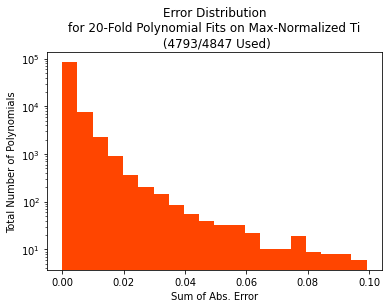


For ('V', 'O'): Ineligible:30, Outliered: 12, Excluded: 149


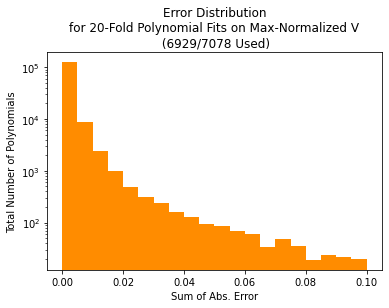


For ('Cr', 'O'): Ineligible:8, Outliered: 18, Excluded: 121


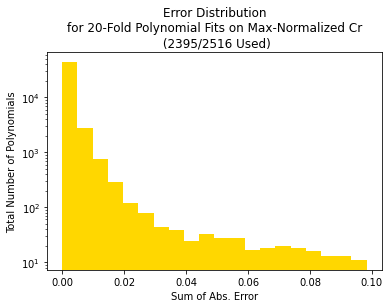


For ('Mn', 'O'): Ineligible:42, Outliered: 504, Excluded: 41


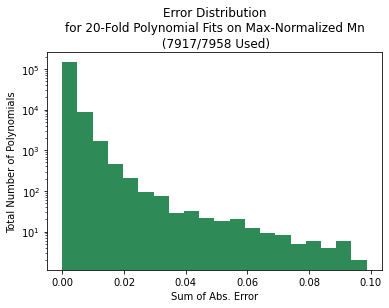


For ('Fe', 'O'): Ineligible:25, Outliered: 523, Excluded: 70


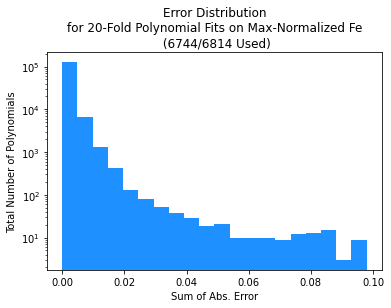


For ('Co', 'O'): Ineligible:7, Outliered: 66, Excluded: 7


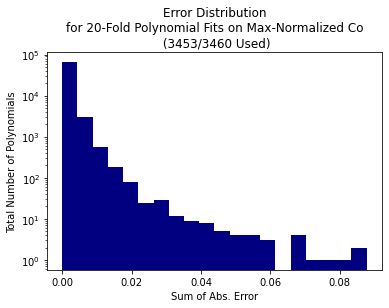


For ('Ni', 'O'): Ineligible:11, Outliered: 12, Excluded: 1


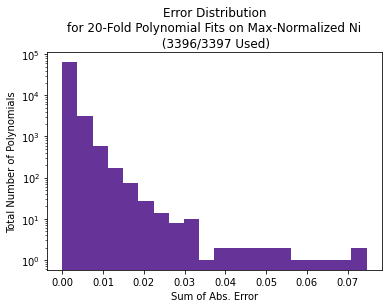


For ('Cu', 'O'): Ineligible:21, Outliered: 31, Excluded: 0


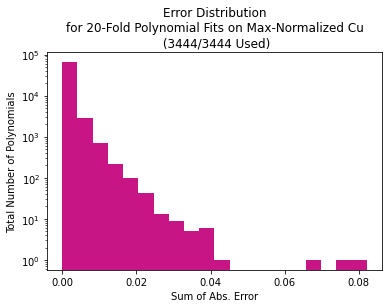


For ('Ti', 'O'): Ineligible:57, Outliered: 26, Excluded: 54


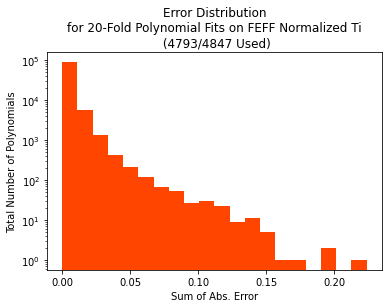


For ('V', 'O'): Ineligible:30, Outliered: 12, Excluded: 149


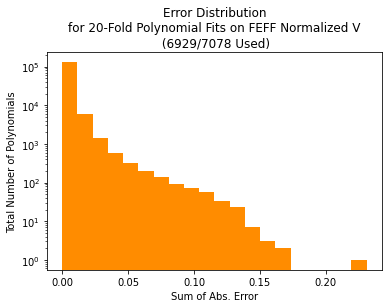


For ('Cr', 'O'): Ineligible:8, Outliered: 18, Excluded: 121


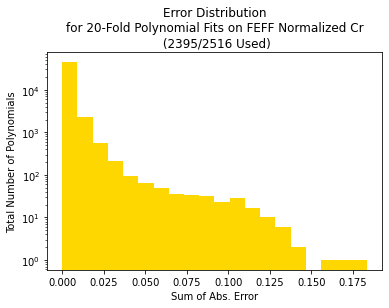


For ('Mn', 'O'): Ineligible:42, Outliered: 504, Excluded: 41


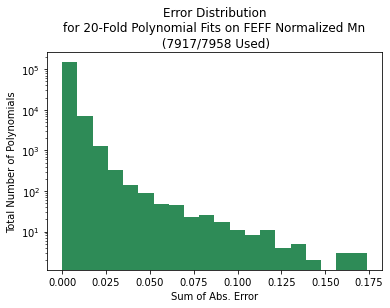


For ('Fe', 'O'): Ineligible:25, Outliered: 523, Excluded: 70


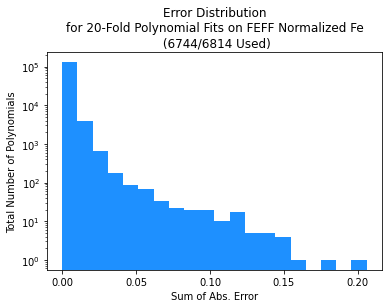


For ('Co', 'O'): Ineligible:7, Outliered: 66, Excluded: 7


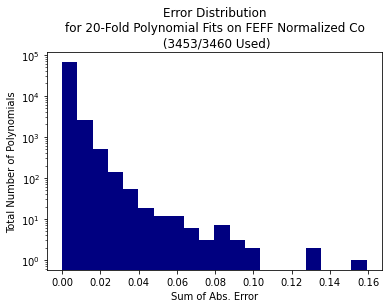


For ('Ni', 'O'): Ineligible:11, Outliered: 12, Excluded: 1


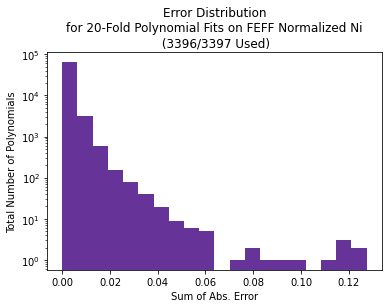


For ('Cu', 'O'): Ineligible:21, Outliered: 31, Excluded: 0


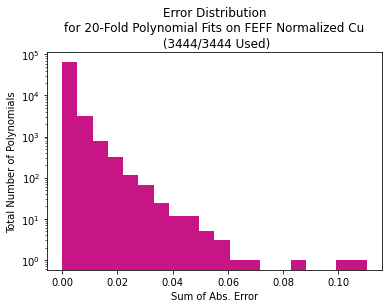

In [7]:
polynomials_by_pair = {pair:[] for pair in target_elements_groups}

for max_normalized in [True,False]:
    norm_str = 'max' if max_normalized else 'feff'

    for pair in target_elements_groups:
        if max_normalized:
            target_file = storage_directory + '/{}_{}norm_polynomial_XY.json'.format(pair[0],norm_str)
        else:
            target_file = storage_directory + '/{}_{}norm_polynomial_XY.json'.format(pair[0],norm_str)


        with open(target_file,'w') as f:
            errors = []
            # Tally spectra which do not pass outlier, data suitability, 
            # or polynomial featurization fidelity criteria
            ineligible = 0 
            outliers = 0
            unfeaturized = 0
            written = 0 
            cond_nums = []
            for dat in tqdm(data_by_pair[pair],desc=pair[0]):
                
                
                if not (dat.get('bader') or dat.get('coordination') in [4,5,6]):
                    ineligible +=1
                    continue
                    
                cur_spec = XAS_Spectrum(dat['E'],dat['mu'])

                if not prune_outliers(cur_spec.y):
                    outliers +=1
                    continue 
                    
                if not one_shot_poly_error_fit(cur_spec.x,cur_spec.y,use_norm=True,error_bound=.1):
                    unfeaturized +=1
                    continue
                    
                if max_normalized:
                    cur_spec.normalize('max')


                cur_cond_nums = []
                cur_errors = []
                poly_set = {}
                peak = cur_spec.get_peak_idx()

                labeled_coefficients = {}
                labeled_coefficients['peak'] = int(peak)
                labeled_coefficients['random'] = np.random.uniform(0,1)

                for n in [4,5,10,20]:
                    poly_set[n] = polynomialize_by_idx(cur_spec.x,cur_spec.y,N=n,deg=3,label_type='frac')
                    for poly in poly_set[n]:
                        cur_cond_nums.append(max(poly.full_data[2])/min(poly.full_data[2]))
                        cond_nums.append(cur_cond_nums[-1])
                        for i, coef in enumerate(poly.coef):
                            coefficient_label = 'loc:all,'+poly.label +',coef:' +str(i)
                            labeled_coefficients[coefficient_label] = coef
                        if n == 20:
                            poly.error = gauge_polynomial_error(poly.x,poly.y,poly,error='abs')
                            cur_errors.append(poly.error)

                errors+=cur_errors
                dat['labeled_coefficients'] = labeled_coefficients
                write_data = {}
                if not dat.get('labeled_coefficients', False):
                    continue
                write_data['labeled_coefficients'] = dat['labeled_coefficients']
                write_data['coordination'] = dat['coordination']
                write_data['one_hot_coord'] = dat['one_hot_coord']
                write_data['bader'] = dat['bader']
                write_data['guessed_oxy'] = dat.get('guessed_oxy',None)

                write_data['nn_indexes'] = dat.get('nn_indexes')
                write_data['nn_species'] =dat.get('nn_species')
                write_data['nn_dists'] = dat.get('nn_dists')
                write_data['avg_nn_dists'] = np.mean(dat.get('nn_dists'))
                write_data['nn_min-max'] = dat.get('nn_min-max')
                write_data['mp_baders'] = dat.get('mp_baders')
                write_data['oqmd_baders'] = dat.get('oqmd_baders')
                write_data['valid_bader'] = dat.get('valid_bader')

                f.write(json.dumps(write_data) + '\n')
                written +=1
            print(f"For {pair}: Ineligible:{ineligible}, Outliered: {outliers}, Excluded: {unfeaturized}")

            norm_str = 'max' if max_normalized else 'feff'
            norm_title = 'Max-Normalized' if max_normalized else 'FEFF Normalized'
            plt.hist(errors,bins=20,color=colors_by_pair[pair])
            plt.title(f"Error Distribution\nfor 20-Fold Polynomial Fits on {norm_title} {pair[0]}\n ({written}/{written+unfeaturized} Used)")
            plt.xlabel("Sum of Abs. Error")
            plt.yscale('log')

            plt.ylabel("Total Number of Polynomials")
            plt.savefig(f"./figures_{norm_str}norm/{pair[0]}_{norm_str}_poly_errors.pdf".format(pair[0],norm_str),format='pdf',dpi=300,bbox_inches='tight',transparent=True)
            plt.show()
